In [25]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
# Load data
df = pd.read_csv('/content/metro_station_peak_hour_data (2).csv')
df.head()

,Time Interval,Day,SpecialEvent,Weather,People Count
0,01-01-2024 00:00,Monday,False,Rainy,10
1,01-01-2024 00:10,Monday,False,Rainy,14
2,01-01-2024 00:20,Monday,False,Cloudy,11
3,01-01-2024 00:30,Monday,False,Rainy,10
4,01-01-2024 00:40,Monday,False,Sunny,10


In [6]:
df['ds'] = pd.to_datetime(df['Time Interval'], format='%d-%m-%Y %H:%M') # Specify the correct format for your date and time strings
df = df.rename(columns={'People Count': 'y'})

In [7]:
# Clean negative values (impossible for people counts)
print(f"Negative values before cleaning: {len(df[df['y'] < 0])}")
df['y'] = df['y'].clip(lower=0)

Negative values before cleaning: 0


In [8]:
# Handle missing values
print(f"Missing values: {df['y'].isnull().sum()}")
df['y'].fillna(method='ffill', inplace=True)

Missing values: 0


<ipython-input-8-29ed113525be>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['y'].fillna(method='ffill', inplace=True)
<ipython-input-8-29ed113525be>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['y'].fillna(method='ffill', inplace=True)


In [9]:
# Remove outliers using IQR
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['y'] >= (Q1 - 1.5 * IQR)) & (df['y'] <= (Q3 + 1.5 * IQR))]

In [10]:
# Add additional features
df['hour'] = df['ds'].dt.hour
df['day_of_week'] = df['ds'].dt.dayofweek

In [11]:
# Define holidays (customize for your metro location)
holidays = pd.DataFrame({
    'holiday': 'public_holiday',
    'ds': pd.to_datetime(['2024-01-26', '2024-08-15', '2024-10-02']),  # Example dates
    'lower_window': -1,
    'upper_window': 1,
})

In [12]:
# Configure advanced Prophet model
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,
    holidays=holidays,
    changepoint_prior_scale=0.05,  # Control trend flexibility
    seasonality_prior_scale=10.0,  # Stronger seasonality
    holidays_prior_scale=5.0,
    seasonality_mode='multiplicative'
)

In [13]:
# Add custom monthly seasonality
model.add_seasonality(
    name='monthly',
    period=30.5,
    fourier_order=5
)

In [14]:
# Add conditional weekly seasonality
def is_weekend(ds):
    date = pd.to_datetime(ds)
    return date.weekday() >= 5

df['weekend'] = df['ds'].apply(is_weekend)
model.add_regressor('weekend')

In [15]:
# Fit model
model.fit(df[['ds', 'y', 'weekend']])

DEBUG:cmdstanpy:input tempfile: /tmp/tmptgod7kbv/psbbwlnn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptgod7kbv/76qhdggt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69006', 'data', 'file=/tmp/tmptgod7kbv/psbbwlnn.json', 'init=/tmp/tmptgod7kbv/76qhdggt.json', 'output', 'file=/tmp/tmptgod7kbv/prophet_modeltghi286c/prophet_model-20250205133540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:35:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:35:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [16]:
# Create future dataframe
future = model.make_future_dataframe(periods=144*7, freq='10T')  # 1 week forecast
future['weekend'] = future['ds'].apply(is_weekend)

/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dates = pd.date_range(


In [17]:
# Generate predictions
forecast = model.predict(future)

In [18]:
# Ensure no negative predictions
forecast['yhat'] = forecast['yhat'].clip(lower=0)

In [22]:
# Cross-validation
# Reduced horizon to 7 days (or you could reduce initial)
df_cv = cross_validation(model, initial='15 days', period='3 days', horizon='7 days')
df_p = performance_metrics(df_cv)
print(f"Cross-validation performance:\n{df_p}")

INFO:prophet:Making 3 forecasts with cutoffs between 2024-01-18 00:00:00 and 2024-01-24 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmptgod7kbv/pruf7czt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptgod7kbv/2uv_2las.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32994', 'data', 'file=/tmp/tmptgod7kbv/pruf7czt.json', 'init=/tmp/tmptgod7kbv/2uv_2las.json', 'output', 'file=/tmp/tmptgod7kbv/prophet_modelslklfw1h/prophet_model-20250205133749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:37:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:37:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmptgod7kbv/6z0kje39.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptgod7kbv/00465804.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Cross-validation performance:
            horizon           mse        rmse         mae      mape     mdape  \
0   0 days 15:50:00   2140.914524   46.270018   36.324814  1.560622  0.874929   
1   0 days 16:00:00   2222.953545   47.148208   37.099557  1.572266  0.888122   
2   0 days 16:10:00   2302.085467   47.980053   37.824851  1.576888  0.906010   
3   0 days 16:20:00   2373.693267   48.720563   38.487994  1.581325  0.920387   
4   0 days 16:30:00   2456.740116   49.565513   39.139262  1.597046  0.928744   
..              ...           ...         ...         ...       ...       ...   
897 6 days 23:20:00  51962.768664  227.953435  175.705846  6.248484  3.754417   
898 6 days 23:30:00  50815.055124  225.421949  173.808381  6.087621  3.691582   
899 6 days 23:40:00  49662.076632  222.849897  171.898449  5.890903  3.561479   
900 6 days 23:50:00  48522.030755  220.277168  170.035621  5.748565  3.561479   
901 7 days 00:00:00  47374.891935  217.657740  168.179698  5.597991  3.533525  

In [23]:
# Calculate final metrics
final_forecast = forecast[['ds', 'yhat']].merge(df[['ds', 'y']], on='ds', how='left')
final_forecast.dropna(inplace=True)

In [26]:
mse = mean_squared_error(final_forecast['y'], final_forecast['yhat'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(final_forecast['y'], final_forecast['yhat'])

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 31.54
MAE: 22.64


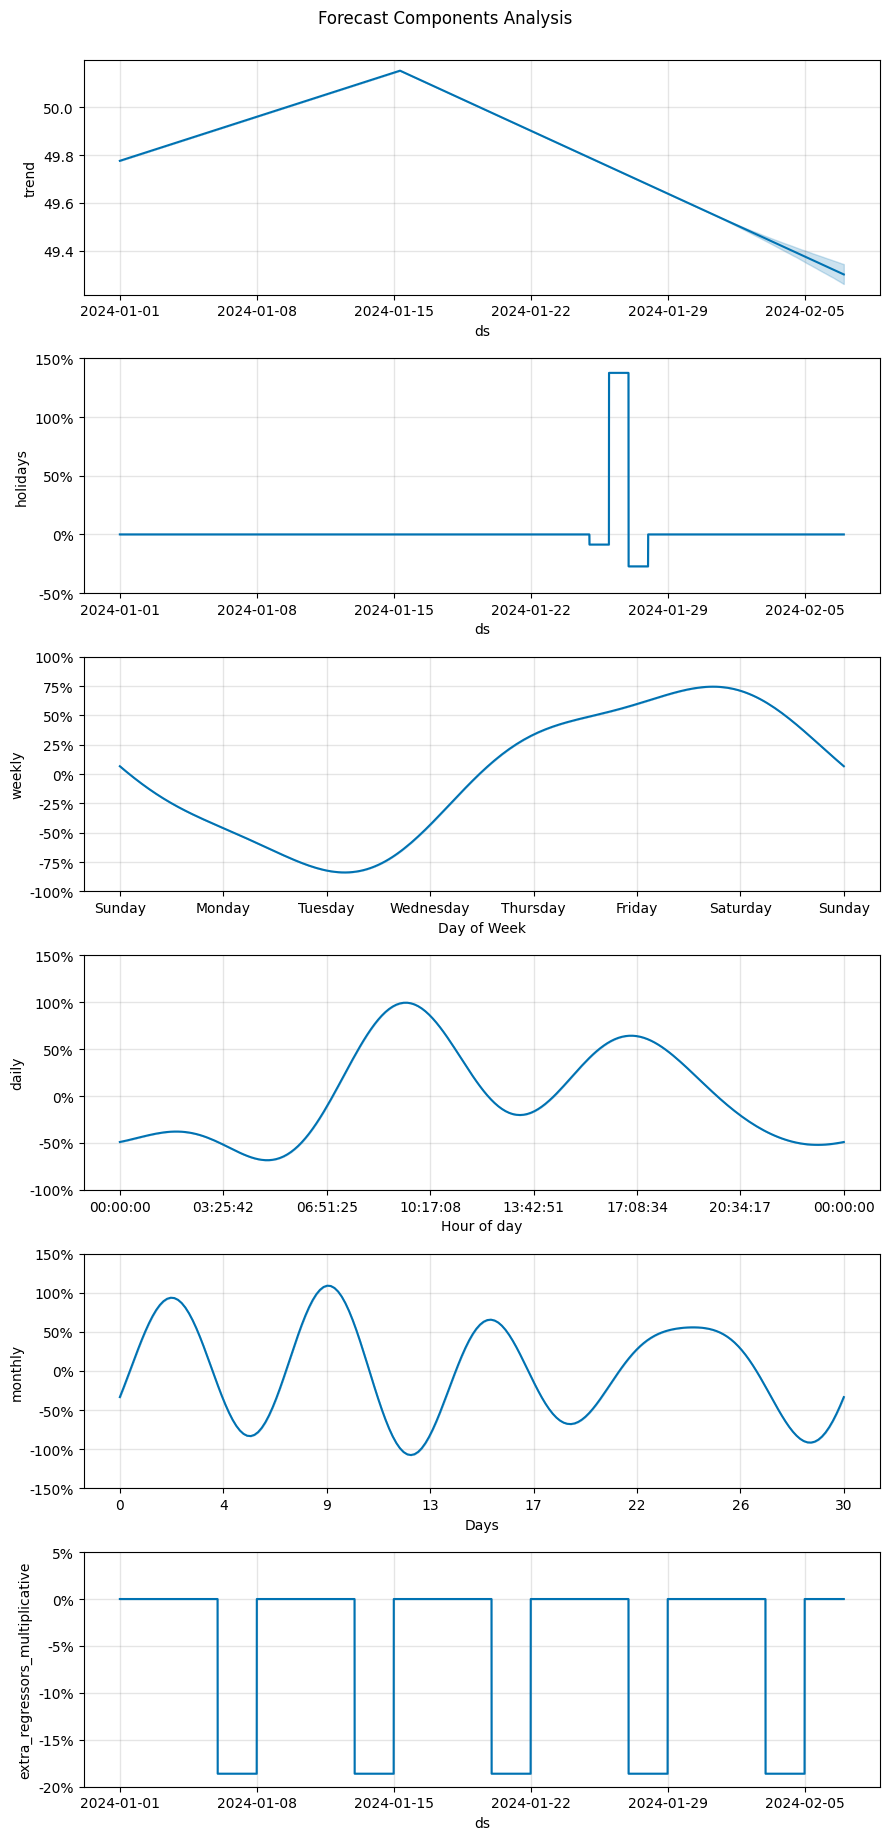

In [27]:
# 1. Forecast Components Analysis
fig_components = model.plot_components(forecast)
plt.suptitle('Forecast Components Analysis', y=1.02)
plt.show()

In [28]:
# 2. Interactive Forecast Plot
from prophet.plot import plot_plotly
fig = plot_plotly(model, forecast)
fig.update_layout(
    title='People Count Forecast with Uncertainty',
    xaxis_title='Date',
    yaxis_title='People Count',
    hovermode='x unified'
)
fig.show()

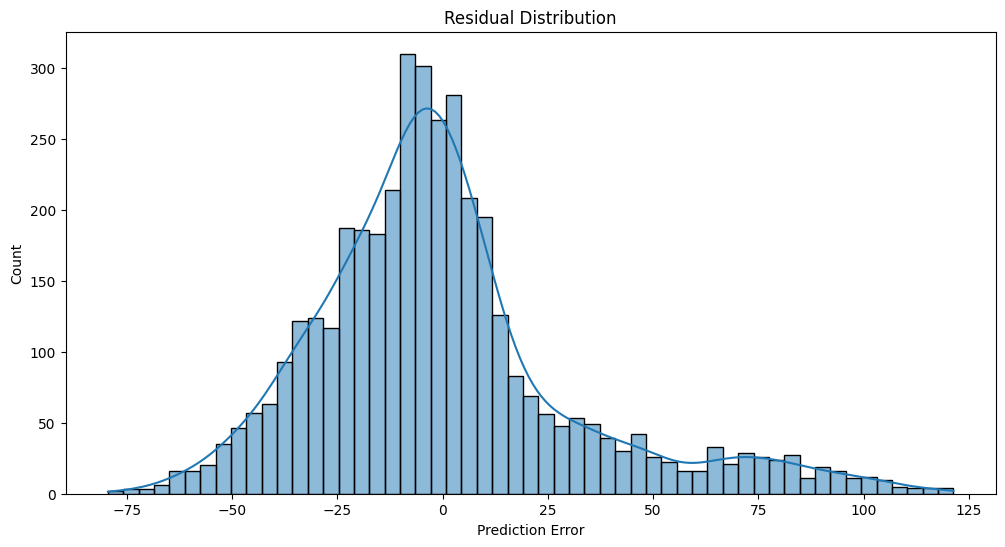

In [29]:
# 3. Residual Analysis
residuals = final_forecast['y'] - final_forecast['yhat']
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')
plt.xlabel('Prediction Error')
plt.show()

<ipython-input-30-3eea40a22864>:2: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



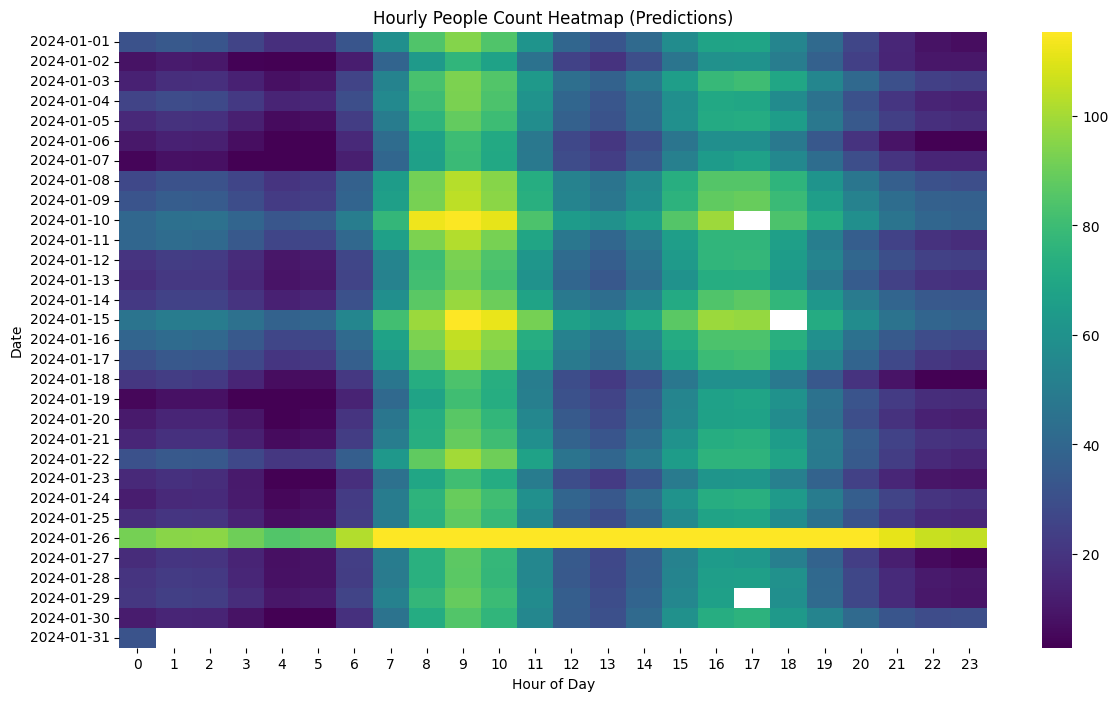

In [30]:
# 4. Hourly Heatmap
heatmap_data = final_forecast.set_index('ds').resample('H').mean()
heatmap_data['hour'] = heatmap_data.index.hour
heatmap_data['date'] = heatmap_data.index.date

plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data.pivot_table(index='date', columns='hour', values='yhat'),
            cmap='viridis', robust=True)
plt.title('Hourly People Count Heatmap (Predictions)')
plt.xlabel('Hour of Day')
plt.ylabel('Date')
plt.show()